# Etude de l'impact des malus 2021 et 2024 sur les emissions de CO2 (en se basant sur le modele logit)
1. Travail sur les données
2. Estimation du CO2 réel avec un modele de machine learning (succes)
3. Calcul du parametre delta calibrant notre modele logit de consommation
4. Test de notre fonction logit part_de_marche avec le delta (succès): les parts de marché estimées avec le malus 2021 correspondent aux ventes 2021

5. Affichage de l'effet des différents malus sur les emissions moyennes de CO2 en se basant sur le modele logit
    (malus basé sur co2 théorique ou réel )

In [ ]:
import numpy as np
np.float=float
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
np.bool = bool
from sklearn.linear_model import Lasso
import re

## 1. Travail sur les données

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#/content/gdrive/MyDrive

In [ ]:
#file_path = '/content/gdrive/MyDrive/psc/data_BLP_caracteristics_CO2_corr.xlsx'

Base rsvero 2021

In [ ]:
#data = pd.read_excel(file_path)
data = pd.read_excel('data_BLP_caracteristics_CO2_corr.xlsx')

In [ ]:
columns=list(data.columns.values)
print(columns)

['type_cnit', 'energ', 'marque_corr', 'modele_corr', 'nb_pl_ass', 'puis_fisc', 'min_year_circ', 'max_year_circ', 'mean_cylindree', 'mean_co2_theorique', 'mean_co2_theorique_corr', 'mean_co2_reel', 'mean_nb_decibels', 'mean_ptr', 'mean_ptac', 'mean_charge_utile', 'mean_puis_kw', 'sd_cylindree', 'sd_co2_theorique', 'sd_co2_theorique_corr', 'sd_co2_reel', 'sd_nb_decibels', 'sd_ptr', 'sd_ptac', 'sd_charge_utile', 'sd_puis_kw', 'N']


Base ADEME 2021

In [ ]:
#file_path2 = '/content/gdrive/MyDrive/psc/ventes 2021_IPP.xlsx'
#data2=pd.read_excel(file_path2)
data2=pd.read_excel('ventes 2021_IPP.xlsx')

In [ ]:
data2.columns

Index(['DATE', 'Genre', 'Marque', 'Type', 'Puissance fiscale', 'Modèle',
       'Version', 'Carrosserie', 'Energie', 'Cylindrée', 'Gamme',
       'Poids à vide', 'Puissance KW', 'Rapport poid puissance',
       'Type de boite', 'Groupe', 'MF/ME', 'Consommation extra-urbaine',
       'Consommation mixte', 'Consommation urbaine', 'BONUS_MALUS',
       'Prix du véhicule', 'CO2_PRF', 'DATE_ARRETE', 'VOLUME', 'JO'],
      dtype='object')

In [ ]:
data.columns

Index(['type_cnit', 'energ', 'marque_corr', 'modele_corr', 'nb_pl_ass',
       'puis_fisc', 'min_year_circ', 'max_year_circ', 'mean_cylindree',
       'mean_co2_theorique', 'mean_co2_theorique_corr', 'mean_co2_reel',
       'mean_nb_decibels', 'mean_ptr', 'mean_ptac', 'mean_charge_utile',
       'mean_puis_kw', 'sd_cylindree', 'sd_co2_theorique',
       'sd_co2_theorique_corr', 'sd_co2_reel', 'sd_nb_decibels', 'sd_ptr',
       'sd_ptac', 'sd_charge_utile', 'sd_puis_kw', 'N'],
      dtype='object')

In [ ]:
data.rename(columns={'type_cnit': 'Type'}, inplace=True) #renomme le cnit

In [ ]:
new_data = pd.merge(data, data2, on='Type', how='inner') #fusionne les 2 par le cnit

In [ ]:
datap=new_data.loc[new_data['N']>20]
datap = datap[['mean_cylindree','mean_co2_theorique','mean_ptr', 'mean_charge_utile','mean_puis_kw', 'mean_co2_reel', 'energ', 'mean_nb_decibels','Prix du véhicule','Carrosserie', 'VOLUME','CO2_PRF']]
print(datap)

       mean_cylindree  mean_co2_theorique  mean_ptr  mean_charge_utile  \
0              4806.0          286.000000    4700.0         530.000000   
1              1598.0          147.000000    2895.0         455.628490   
3              1582.0          108.000000    3420.0         560.456938   
4                 NaN            0.000000       NaN         385.000000   
5                 NaN            0.000000       NaN         470.000000   
...               ...                 ...       ...                ...   
54158           998.0          127.086957    2830.0         530.000000   
54202           999.0          126.750000    2690.0         499.750000   
54203           999.0          126.750000    2690.0         499.750000   
54204           999.0          126.750000    2690.0         499.750000   
54529          2894.0           76.782609       NaN         595.000000   

       mean_puis_kw  mean_co2_reel energ  mean_nb_decibels  Prix du véhicule  \
0        368.000000     358.498

In [ ]:
datap.dropna(inplace=True)
datap.describe()

,mean_cylindree,mean_co2_theorique,mean_ptr,mean_charge_utile,mean_puis_kw,mean_co2_reel,mean_nb_decibels,Prix du véhicule,VOLUME,CO2_PRF
count,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000
mean,1626.548577,130.309693,3559.407031,592.092125,111.986209,154.535375,74.125434,39194.742269,34.497914,131.311487
std,464.653106,33.643105,775.139234,89.668620,40.426663,29.534750,3.708701,16394.487896,162.132949,34.722368
min,874.102052,0.000000,0.000000,224.074713,26.300000,0.000000,56.000000,8890.000000,1.000000,0.000000
25%,1332.000000,122.909563,2990.000000,540.735849,88.000000,142.348936,72.000000,28350.000000,1.000000,124.000000
50%,1499.000000,134.838150,3470.000000,575.000000,110.000000,155.775000,74.000000,36090.000000,4.000000,136.000000
75%,1968.000000,147.485714,3935.000000,615.840000,120.000000,168.852000,76.000000,45724.000000,14.000000,149.000000
max,5000.000000,373.000000,6850.000000,1243.000000,478.000000,405.892593,96.000000,205715.000000,6754.000000,373.000000


In [ ]:
datap.columns

Index(['mean_cylindree', 'mean_co2_theorique', 'mean_ptr', 'mean_charge_utile',
       'mean_puis_kw', 'mean_co2_reel', 'energ', 'mean_nb_decibels',
       'Prix du véhicule', 'Carrosserie', 'VOLUME', 'CO2_PRF'],
      dtype='object')

In [ ]:
datap['energ'].unique()

array(['ES', 'GO', 'FE', 'EE', 'EH', 'GH', 'EL', 'GN', 'GL', 'EG', 'FH',
       'EN'], dtype=object)

In [ ]:
emissions_theoriques = 0
emissions_reelles = 0
ventes_totales = 0
valeurs_colonne_co2_reel = datap['mean_co2_reel']
valeurs_colonne_co2_theorique = datap['mean_co2_theorique']
valeurs_colonne_ventes = datap['VOLUME']

In [ ]:
np.sum(valeurs_colonne_ventes*valeurs_colonne_co2_reel)/np.sum(valeurs_colonne_ventes)

141.41995121496478

In [ ]:
np.sum(valeurs_colonne_ventes*datap['mean_co2_theorique'])/np.sum(valeurs_colonne_ventes)

119.14878070141394

## 2. Estimation du CO2 réel avec le machine learning

In [ ]:
y=datap['mean_co2_reel']
dataOG=new_data['mean_co2_theorique']
dataEtat=datap['mean_co2_theorique']

for col in list(datap['energ'].unique()):
    datap[col]=(datap['energ']==col)*1

for col in list(datap['Carrosserie'].unique()):
    datap[col]=(datap['Carrosserie']==col)*1

datap_train = datap.loc[-datap['energ'].isin(['EL'])] # sans éléctrique

datap_train=datap_train.drop('energ', axis=1)
datap_train=datap_train.drop('Carrosserie', axis=1)
datap=datap.drop('energ', axis=1)
datap=datap.drop('Carrosserie', axis=1)
y_sel = datap_train['mean_co2_reel']
datap_train=datap_train.drop(['mean_co2_reel', 'VOLUME', 'Prix du véhicule', ], axis=1)
datas=datap.drop(['mean_co2_reel', 'VOLUME', 'Prix du véhicule'], axis=1)

def normalization(dataToNormalize):
    columns=list(dataToNormalize.columns) # liste colonnes
    scaler=preprocessing.StandardScaler()
    for col in columns:
        dataToNormalize.loc[:,col]=scaler.fit_transform(dataToNormalize.loc[:,col].values.reshape(-1,1))


normalization(datap_train)
normalization(datas)

x_train, x_test, y_train, y_test = train_test_split(datap_train, y_sel, test_size=0.2)
lasso_model = Lasso(alpha=0.2)
lasso_model.fit(x_train, y_train)
test_predictions_lasso = lasso_model.predict(x_test)

print(f"RMSE_model = {round(sqrt(mean_squared_error(y_test,test_predictions_lasso)),3)}")

print(f"R2_score_model = {round(r2_score(y_test, test_predictions_lasso),3)}")

datap['CO2reel'] = lasso_model.predict(datas)

datap.loc[datap['EL']==1, 'CO2reel']=0

CO2reel=datap['CO2reel']

/tmp/ipykernel_121/1175417484.py:25: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataToNormalize.loc[:,col]=scaler.fit_transform(dataToNormalize.loc[:,col].values.reshape(-1,1))


RMSE_model = 9.117
R2_score_model = 0.907


## 3. Code du Malus 2021 et 2024

### Malus 2021

In [ ]:
file_path = '/content/gdrive/MyDrive/psc/malus_2021.xlsx'

In [ ]:
#malus_2021_df = pd.read_excel('/content/gdrive/MyDrive/psc/malus_2021.xlsx')
malus_2021_df = pd.read_excel('malus_2021.xlsx')
malus_2021_df.rename(columns={"Taux d'émission de CO2 par kilomètre": "CO2"}, inplace=True)

def malus_etat_2021(c):
    if int(c)<=132:
        return 0
    if int(c)>=219:
        return 30000
    else:
        return int( malus_2021_df.loc[malus_2021_df['CO2'] == int(c)]['Montant'])

In [ ]:
datap['malus_2021'] = pd.to_numeric(datap['mean_co2_theorique'].apply(malus_etat_2021), errors='coerce')

In [ ]:
datap['malus_2021_reel'] = pd.to_numeric(datap['mean_co2_reel'].apply(malus_etat_2021), errors='coerce')

### Malus 2024

In [ ]:
malus_2024_df = pd.read_excel('malus_2024.xlsx')

# https://www.service-public.fr/particuliers/vosdroits/F35947

malus_2024_df.rename(columns={"Taux d'émission de CO2 par kilomètre": "CO2"}, inplace=True) # colonnes ['CO2', 'Montant']

def malus_etat_2024(c):
    if int(c)<=117:
        return 0
    elif int(c)>=193:
        return 60000
    else:
        return int (malus_2024_df.loc[malus_2024_df['CO2'] == str(int(c))+' g']['Montant'])

In [ ]:
datap['malus_2024'] = pd.to_numeric(datap['mean_co2_theorique'].apply(malus_etat_2024), errors='coerce')

In [ ]:
datap['malus_2024_reel'] = pd.to_numeric(datap['mean_co2_reel'].apply(malus_etat_2024), errors='coerce')

## 3. Calcul du parametre delta calibrant notre modele logit de consommation

In [ ]:
p2021 = datap['Prix du véhicule'] + datap['malus_2021']

quantite = datap['VOLUME']

In [ ]:
quantite.describe()

count    39549.000000
mean        34.497914
std        162.132949
min          1.000000
25%          1.000000
50%          4.000000
75%         14.000000
max       6754.000000
Name: VOLUME, dtype: float64

In [ ]:
beta = -0.00015
delta = beta*(p2021.iloc[len(p2021)-1]-p2021)+np.log(quantite/(quantite.iloc[len(quantite)-1]))

In [ ]:
datap['delta_modele'] = delta

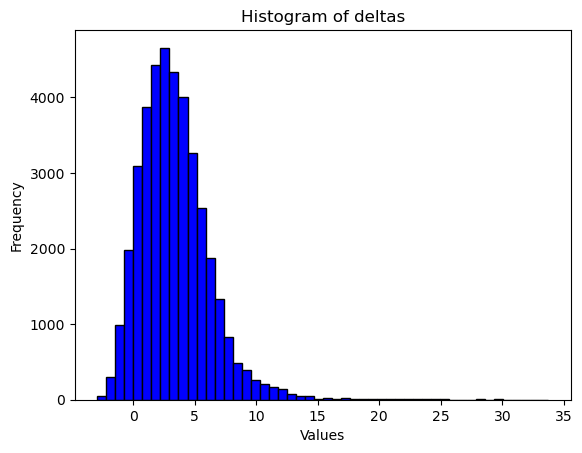

In [ ]:
# Assuming 'data' is your DataFrame and 'column_name' is the name of the column you want to plot
plt.hist(datap['delta_modele'], bins=50, color='blue', edgecolor='black')  # You can adjust the number of bins and color
plt.title('Histogram of deltas')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()


In [ ]:
datap.columns

Index(['mean_cylindree', 'mean_co2_theorique', 'mean_ptr', 'mean_charge_utile',
       'mean_puis_kw', 'mean_co2_reel', 'mean_nb_decibels', 'Prix du véhicule',
       'VOLUME', 'CO2_PRF', 'ES', 'GO', 'FE', 'EE', 'EH', 'GH', 'EL', 'GN',
       'GL', 'EG', 'FH', 'EN', 'BERLINE', 'TS TERRAINS/CHEMINS', 'BREAK',
       'MINIBUS', 'MONOSPACE COMPACT', 'COMBISPACE', 'COUPE', 'MONOSPACE',
       'MINISPACE', 'CABRIOLET', 'CO2reel', 'malus_2021', 'malus_2021_reel',
       'malus_2024', 'malus_2024_reel', 'delta_modele'],
      dtype='object')

In [ ]:
#datap = datap[['mean_co2_theorique','mean_cylindree','nb_pl_ass', 'mean_co2_reel', 'energ','mean_nb_decibels', 'mean_ptr', 'mean_ptac', 'mean_charge_utile','mean_puis_kw', 'Prix du véhicule', 'VOLUME','Carrosserie', 'malus_2021','delta_modele']]
datap

,mean_cylindree,mean_co2_theorique,mean_ptr,mean_charge_utile,mean_puis_kw,mean_co2_reel,mean_nb_decibels,Prix du véhicule,VOLUME,CO2_PRF,...,COUPE,MONOSPACE,MINISPACE,CABRIOLET,CO2reel,malus_2021,malus_2021_reel,malus_2024,malus_2024_reel,delta_modele
0,4806.000000,286.000000,4700.0,530.000000,368.00000,358.498030,77.0,142807.0,1,286,...,0,0,0,0,331.146955,30000,30000,60000,60000,21.642903
1,1598.000000,147.000000,2895.0,455.628490,86.00000,181.021890,72.0,25254.0,1,147,...,0,0,0,0,164.422546,360,6039,1761,24291,-0.436047
3,1582.000000,108.000000,3420.0,560.456938,81.00000,151.611933,77.0,23905.0,1,108,...,0,0,0,0,125.784585,0,650,0,2370,-0.692397
7,1560.000000,100.000000,3160.0,569.984985,88.00000,140.958233,72.0,30371.0,1,100,...,0,0,0,0,121.145914,0,210,0,983,0.277503
9,1198.981607,104.000000,2366.0,570.998824,59.99908,149.158444,76.0,17736.0,1,104,...,0,0,0,0,127.541382,0,450,0,2049,-1.617747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54157,998.000000,127.086957,2830.0,530.000000,88.30000,152.752174,72.0,29733.0,18,127,...,0,0,0,0,150.030655,0,740,240,2544,3.072175
54158,998.000000,127.086957,2830.0,530.000000,88.30000,152.752174,72.0,29933.0,1,127,...,0,0,0,0,150.030655,0,740,240,2544,0.211803
54202,999.000000,126.750000,2690.0,499.750000,91.90000,139.100000,72.0,22825.0,5,126,...,0,0,0,0,149.960825,0,190,230,898,0.755041
54203,999.000000,126.750000,2690.0,499.750000,91.90000,139.100000,72.0,22825.0,21,127,...,0,0,0,0,150.132459,0,190,230,898,2.190125


In [ ]:
datap[['mean_co2_theorique','malus_2021']].corr()

,mean_co2_theorique,malus_2021
mean_co2_theorique,1.000000,0.476102
malus_2021,0.476102,1.000000


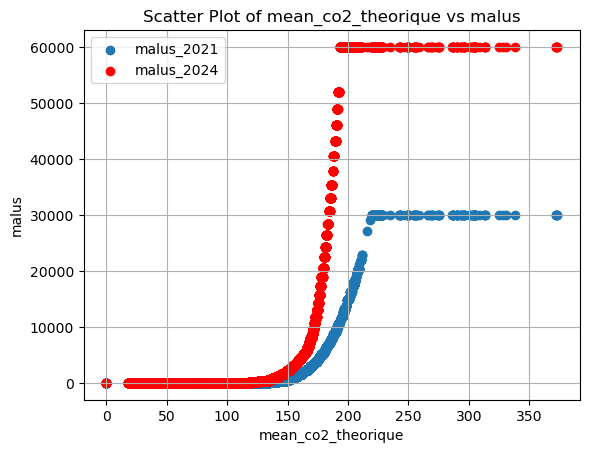

In [ ]:
plt.scatter(datap['mean_co2_theorique'], datap['malus_2021'], label='malus_2021')
plt.scatter(datap['mean_co2_theorique'], datap['malus_2024'], label='malus_2024', color='r')
plt.title('Scatter Plot of mean_co2_theorique vs malus')
plt.xlabel('mean_co2_theorique')
plt.ylabel('malus')
plt.grid(True)  # Optional: Adds a grid for better readability
plt.legend()
plt.show()

In [ ]:
print(datap['malus_2021'].mean())
print(np.average(datap['malus_2021'], weights=datap['VOLUME']))

698.8260891552252
187.87181296990966


## 6. Affichage de l'effet des différents malus sur les emissions moyennes de CO2

In [ ]:
m_guess = np.zeros(datap['VOLUME'].size)
m_guess

array([0., 0., 0., ..., 0., 0., 0.])

### Effet malus 2021 basé sur CO2 théorique

In [ ]:
# categorisation selon le malus 2021 théorique
bins_limits = np.concatenate([np.array([0, 132])] + [malus_2021_df['CO2'][1:-1].values] + [np.array([219, 420])])

# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_theorique'], bins=bins_limits, include_lowest=True, right=False)
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

# malus
malus_2021=datap.groupby('CO2bins')['malus_2021'].mean() #2021 sur theorique

In [ ]:
p

CO2bins
[0, 132)       27965.388860
[132, 133)     28634.642975
[133, 134)     28779.890471
[134, 135)     29522.407437
[135, 136)     33008.878360
                  ...      
[215, 216)              NaN
[216, 217)     96297.000000
[217, 218)              NaN
[218, 219)    102375.000000
[219, 420)    109553.860800
Length: 89, dtype: float64

## effet malus 2021 basé sur le co2 réel

In [ ]:
# categorisation selon le malus 2021 réel
bins_limits = np.concatenate([np.array([0, 132])] + [malus_2021_df['CO2'][1:-1].values] + [np.array([219, 420])])

# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_reel'], bins=bins_limits, include_lowest=True, right=False) #CO2 réel
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

malus_2021_reel = datap.groupby('CO2bins')['malus_2021_reel'].min()
malus_2021_reel



CO2bins
[0, 132)          0
[132, 133)        0
[133, 134)       50
[134, 135)       75
[135, 136)      100
              ...  
[215, 216)    26247
[216, 217)    27166
[217, 218)    28107
[218, 219)    29070
[219, 420)    30000
Name: malus_2021_reel, Length: 89, dtype: int64

### Effet malus 2024

In [ ]:
datap['malus_2024']

0        60000
1         1761
3            0
7            0
9            0
         ...  
54157      240
54158      240
54202      230
54203      230
54204      230
Name: malus_2024, Length: 39549, dtype: int64

#### a. Visualisation du malus 2024 basé sur le co2 théorique

In [ ]:
def make_int(s):
    return int(re.search(r'\d+', s).group())

make_int_vf = np.vectorize(make_int)
make_int_vf(malus_2024_df['CO2'][1:-1].values)

array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193])

## Nouvelle catégorisation 2024 avec plus de catégories élevées 

In [ ]:
p

CO2bins
[0, 117)       34036.514591
[117, 118)     21696.348996
[118, 119)     22133.458549
[119, 120)     21616.704205
[120, 121)     20765.294717
                  ...      
[215, 216)              NaN
[216, 217)     96297.000000
[217, 218)              NaN
[218, 219)    102375.000000
[219, 420)    109553.860800
Length: 104, dtype: float64

## malus 2024 sur co2 réel

In [ ]:
def make_int(s):
    return int(re.search(r'\d+', s).group())

make_int_vf = np.vectorize(make_int)
liste_bins_malus_2024 = make_int_vf(malus_2024_df['CO2'][1:-1].values)
liste_bins_malus_2024

array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193])

In [ ]:
# categorisation selon le malus 2024 sur co2 réel
bins_limits = np.concatenate([np.array([0, 60, 90, 100, 117])] + [liste_bins_malus_2024] +[np.arange(194, 220,3)]+ [np.array([ 420])])
                                                                               
# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_reel'], bins=bins_limits, include_lowest=True, right=False)
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

# malus
malus_2024_reel=datap.groupby('CO2bins')['malus_2024_reel'].mean()

In [ ]:
malus_2024_reel

CO2bins
[0, 60)           0.0
[60, 90)          0.0
[90, 100)         0.0
[100, 117)        0.0
[117, 118)        0.0
               ...   
[206, 209)    60000.0
[209, 212)    60000.0
[212, 215)    60000.0
[215, 218)    60000.0
[218, 420)    60000.0
Name: malus_2024_reel, Length: 90, dtype: float64

In [ ]:
p

CO2bins
[0, 60)       48424.338402
[60, 90)      46524.975766
[90, 100)     50136.850764
[100, 117)    28936.667429
[117, 118)    29230.459290
                  ...     
[206, 209)    54331.880859
[209, 212)    42323.159395
[212, 215)    73564.338028
[215, 218)    56419.785791
[218, 420)    77440.391569
Length: 90, dtype: float64

In [ ]:
datap.groupby('CO2bins')['VOLUME'].sum()

CO2bins
[0, 117)      189745
[117, 118)     10366
[118, 119)      5465
[119, 120)     25352
[120, 121)      3918
               ...  
[215, 216)       408
[216, 217)       770
[217, 218)       694
[218, 219)        68
[219, 420)      2399
Name: VOLUME, Length: 104, dtype: int64

# Etude de l'impact des malus 2021 et 2024 sur les emissions de CO2 (en se basant sur le modele logit)
1. Travail sur les données
2. Estimation du CO2 réel avec un modele de machine learning (succes)
3. Calcul du parametre delta calibrant notre modele logit de consommation
4. Test de notre fonction logit part_de_marche avec le delta (succès): les parts de marché estimées avec le malus 2021 correspondent aux ventes 2021

5. Affichage de l'effet des différents malus sur les emissions moyennes de CO2 en se basant sur le modele logit
    (malus basé sur co2 théorique ou réel )

In [1]:
import numpy as np
np.float=float
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
np.bool = bool
from sklearn.linear_model import Lasso
import re

## 1. Travail sur les données

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
#/content/gdrive/MyDrive

In [4]:
#file_path = '/content/gdrive/MyDrive/psc/data_BLP_caracteristics_CO2_corr.xlsx'

Base rsvero 2021

In [5]:
#data = pd.read_excel(file_path)
data = pd.read_excel('data_BLP_caracteristics_CO2_corr.xlsx')

In [6]:
columns=list(data.columns.values)
print(columns)

['type_cnit', 'energ', 'marque_corr', 'modele_corr', 'nb_pl_ass', 'puis_fisc', 'min_year_circ', 'max_year_circ', 'mean_cylindree', 'mean_co2_theorique', 'mean_co2_theorique_corr', 'mean_co2_reel', 'mean_nb_decibels', 'mean_ptr', 'mean_ptac', 'mean_charge_utile', 'mean_puis_kw', 'sd_cylindree', 'sd_co2_theorique', 'sd_co2_theorique_corr', 'sd_co2_reel', 'sd_nb_decibels', 'sd_ptr', 'sd_ptac', 'sd_charge_utile', 'sd_puis_kw', 'N']


Base ADEME 2021

In [7]:
#file_path2 = '/content/gdrive/MyDrive/psc/ventes 2021_IPP.xlsx'
#data2=pd.read_excel(file_path2)
data2=pd.read_excel('ventes 2021_IPP.xlsx')

In [8]:
data2.columns

Index(['DATE', 'Genre', 'Marque', 'Type', 'Puissance fiscale', 'Modèle',
       'Version', 'Carrosserie', 'Energie', 'Cylindrée', 'Gamme',
       'Poids à vide', 'Puissance KW', 'Rapport poid puissance',
       'Type de boite', 'Groupe', 'MF/ME', 'Consommation extra-urbaine',
       'Consommation mixte', 'Consommation urbaine', 'BONUS_MALUS',
       'Prix du véhicule', 'CO2_PRF', 'DATE_ARRETE', 'VOLUME', 'JO'],
      dtype='object')

In [9]:
data.columns

Index(['type_cnit', 'energ', 'marque_corr', 'modele_corr', 'nb_pl_ass',
       'puis_fisc', 'min_year_circ', 'max_year_circ', 'mean_cylindree',
       'mean_co2_theorique', 'mean_co2_theorique_corr', 'mean_co2_reel',
       'mean_nb_decibels', 'mean_ptr', 'mean_ptac', 'mean_charge_utile',
       'mean_puis_kw', 'sd_cylindree', 'sd_co2_theorique',
       'sd_co2_theorique_corr', 'sd_co2_reel', 'sd_nb_decibels', 'sd_ptr',
       'sd_ptac', 'sd_charge_utile', 'sd_puis_kw', 'N'],
      dtype='object')

In [10]:
data.rename(columns={'type_cnit': 'Type'}, inplace=True) #renomme le cnit

In [11]:
new_data = pd.merge(data, data2, on='Type', how='inner') #fusionne les 2 par le cnit

In [12]:
datap=new_data.loc[new_data['N']>20]
datap = datap[['mean_cylindree','mean_co2_theorique','mean_ptr', 'mean_charge_utile','mean_puis_kw', 'mean_co2_reel', 'energ', 'mean_nb_decibels','Prix du véhicule','Carrosserie', 'VOLUME','CO2_PRF']]
print(datap)

       mean_cylindree  mean_co2_theorique  mean_ptr  mean_charge_utile  \
0              4806.0          286.000000    4700.0         530.000000   
1              1598.0          147.000000    2895.0         455.628490   
3              1582.0          108.000000    3420.0         560.456938   
4                 NaN            0.000000       NaN         385.000000   
5                 NaN            0.000000       NaN         470.000000   
...               ...                 ...       ...                ...   
54158           998.0          127.086957    2830.0         530.000000   
54202           999.0          126.750000    2690.0         499.750000   
54203           999.0          126.750000    2690.0         499.750000   
54204           999.0          126.750000    2690.0         499.750000   
54529          2894.0           76.782609       NaN         595.000000   

       mean_puis_kw  mean_co2_reel energ  mean_nb_decibels  Prix du véhicule  \
0        368.000000     358.498

In [13]:
datap.dropna(inplace=True)
datap.describe()

,mean_cylindree,mean_co2_theorique,mean_ptr,mean_charge_utile,mean_puis_kw,mean_co2_reel,mean_nb_decibels,Prix du véhicule,VOLUME,CO2_PRF
count,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000,39549.000000
mean,1626.548577,130.309693,3559.407031,592.092125,111.986209,154.535375,74.125434,39194.742269,34.497914,131.311487
std,464.653106,33.643105,775.139234,89.668620,40.426663,29.534750,3.708701,16394.487896,162.132949,34.722368
min,874.102052,0.000000,0.000000,224.074713,26.300000,0.000000,56.000000,8890.000000,1.000000,0.000000
25%,1332.000000,122.909563,2990.000000,540.735849,88.000000,142.348936,72.000000,28350.000000,1.000000,124.000000
50%,1499.000000,134.838150,3470.000000,575.000000,110.000000,155.775000,74.000000,36090.000000,4.000000,136.000000
75%,1968.000000,147.485714,3935.000000,615.840000,120.000000,168.852000,76.000000,45724.000000,14.000000,149.000000
max,5000.000000,373.000000,6850.000000,1243.000000,478.000000,405.892593,96.000000,205715.000000,6754.000000,373.000000


In [14]:
datap.columns

Index(['mean_cylindree', 'mean_co2_theorique', 'mean_ptr', 'mean_charge_utile',
       'mean_puis_kw', 'mean_co2_reel', 'energ', 'mean_nb_decibels',
       'Prix du véhicule', 'Carrosserie', 'VOLUME', 'CO2_PRF'],
      dtype='object')

In [15]:
datap['energ'].unique()

array(['ES', 'GO', 'FE', 'EE', 'EH', 'GH', 'EL', 'GN', 'GL', 'EG', 'FH',
       'EN'], dtype=object)

In [16]:
emissions_theoriques = 0
emissions_reelles = 0
ventes_totales = 0
valeurs_colonne_co2_reel = datap['mean_co2_reel']
valeurs_colonne_co2_theorique = datap['mean_co2_theorique']
valeurs_colonne_ventes = datap['VOLUME']

In [17]:
np.sum(valeurs_colonne_ventes*valeurs_colonne_co2_reel)/np.sum(valeurs_colonne_ventes)

141.41995121496478

In [18]:
np.sum(valeurs_colonne_ventes*datap['mean_co2_theorique'])/np.sum(valeurs_colonne_ventes)

119.14878070141394

## 2. Estimation du CO2 réel avec le machine learning

In [19]:
y=datap['mean_co2_reel']
dataOG=new_data['mean_co2_theorique']
dataEtat=datap['mean_co2_theorique']

for col in list(datap['energ'].unique()):
    datap[col]=(datap['energ']==col)*1

for col in list(datap['Carrosserie'].unique()):
    datap[col]=(datap['Carrosserie']==col)*1

datap_train = datap.loc[-datap['energ'].isin(['EL'])] # sans éléctrique

datap_train=datap_train.drop('energ', axis=1)
datap_train=datap_train.drop('Carrosserie', axis=1)
datap=datap.drop('energ', axis=1)
datap=datap.drop('Carrosserie', axis=1)
y_sel = datap_train['mean_co2_reel']
datap_train=datap_train.drop(['mean_co2_reel', 'VOLUME', 'Prix du véhicule', ], axis=1)
datas=datap.drop(['mean_co2_reel', 'VOLUME', 'Prix du véhicule'], axis=1)

def normalization(dataToNormalize):
    columns=list(dataToNormalize.columns) # liste colonnes
    scaler=preprocessing.StandardScaler()
    for col in columns:
        dataToNormalize.loc[:,col]=scaler.fit_transform(dataToNormalize.loc[:,col].values.reshape(-1,1))


normalization(datap_train)
normalization(datas)

x_train, x_test, y_train, y_test = train_test_split(datap_train, y_sel, test_size=0.2)
lasso_model = Lasso(alpha=0.2)
lasso_model.fit(x_train, y_train)
test_predictions_lasso = lasso_model.predict(x_test)

print(f"RMSE_model = {round(sqrt(mean_squared_error(y_test,test_predictions_lasso)),3)}")

print(f"R2_score_model = {round(r2_score(y_test, test_predictions_lasso),3)}")

datap['CO2reel'] = lasso_model.predict(datas)

datap.loc[datap['EL']==1, 'CO2reel']=0

CO2reel=datap['CO2reel']

/tmp/ipykernel_121/1175417484.py:25: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataToNormalize.loc[:,col]=scaler.fit_transform(dataToNormalize.loc[:,col].values.reshape(-1,1))


RMSE_model = 9.117
R2_score_model = 0.907


## 3. Code du Malus 2021 et 2024

### Malus 2021

In [20]:
file_path = '/content/gdrive/MyDrive/psc/malus_2021.xlsx'

In [21]:
#malus_2021_df = pd.read_excel('/content/gdrive/MyDrive/psc/malus_2021.xlsx')
malus_2021_df = pd.read_excel('malus_2021.xlsx')
malus_2021_df.rename(columns={"Taux d'émission de CO2 par kilomètre": "CO2"}, inplace=True)

def malus_etat_2021(c):
    if int(c)<=132:
        return 0
    if int(c)>=219:
        return 30000
    else:
        return int( malus_2021_df.loc[malus_2021_df['CO2'] == int(c)]['Montant'])

In [22]:
datap['malus_2021'] = pd.to_numeric(datap['mean_co2_theorique'].apply(malus_etat_2021), errors='coerce')

In [23]:
datap['malus_2021_reel'] = pd.to_numeric(datap['mean_co2_reel'].apply(malus_etat_2021), errors='coerce')

### Malus 2024

In [24]:
malus_2024_df = pd.read_excel('malus_2024.xlsx')

# https://www.service-public.fr/particuliers/vosdroits/F35947

malus_2024_df.rename(columns={"Taux d'émission de CO2 par kilomètre": "CO2"}, inplace=True) # colonnes ['CO2', 'Montant']

def malus_etat_2024(c):
    if int(c)<=117:
        return 0
    elif int(c)>=193:
        return 60000
    else:
        return int (malus_2024_df.loc[malus_2024_df['CO2'] == str(int(c))+' g']['Montant'])

In [25]:
datap['malus_2024'] = pd.to_numeric(datap['mean_co2_theorique'].apply(malus_etat_2024), errors='coerce')

In [26]:
datap['malus_2024_reel'] = pd.to_numeric(datap['mean_co2_reel'].apply(malus_etat_2024), errors='coerce')

## 3. Calcul du parametre delta calibrant notre modele logit de consommation

In [27]:
p2021 = datap['Prix du véhicule'] + datap['malus_2021']

quantite = datap['VOLUME']

In [28]:
quantite.describe()

count    39549.000000
mean        34.497914
std        162.132949
min          1.000000
25%          1.000000
50%          4.000000
75%         14.000000
max       6754.000000
Name: VOLUME, dtype: float64

In [29]:
beta = -0.00015
delta = beta*(p2021.iloc[len(p2021)-1]-p2021)+np.log(quantite/(quantite.iloc[len(quantite)-1]))

In [30]:
datap['delta_modele'] = delta

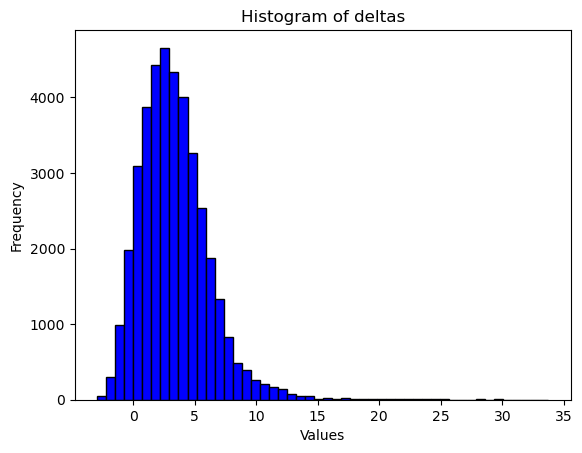

In [31]:
# Assuming 'data' is your DataFrame and 'column_name' is the name of the column you want to plot
plt.hist(datap['delta_modele'], bins=50, color='blue', edgecolor='black')  # You can adjust the number of bins and color
plt.title('Histogram of deltas')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()


In [32]:
datap.columns

Index(['mean_cylindree', 'mean_co2_theorique', 'mean_ptr', 'mean_charge_utile',
       'mean_puis_kw', 'mean_co2_reel', 'mean_nb_decibels', 'Prix du véhicule',
       'VOLUME', 'CO2_PRF', 'ES', 'GO', 'FE', 'EE', 'EH', 'GH', 'EL', 'GN',
       'GL', 'EG', 'FH', 'EN', 'BERLINE', 'TS TERRAINS/CHEMINS', 'BREAK',
       'MINIBUS', 'MONOSPACE COMPACT', 'COMBISPACE', 'COUPE', 'MONOSPACE',
       'MINISPACE', 'CABRIOLET', 'CO2reel', 'malus_2021', 'malus_2021_reel',
       'malus_2024', 'malus_2024_reel', 'delta_modele'],
      dtype='object')

In [33]:
#datap = datap[['mean_co2_theorique','mean_cylindree','nb_pl_ass', 'mean_co2_reel', 'energ','mean_nb_decibels', 'mean_ptr', 'mean_ptac', 'mean_charge_utile','mean_puis_kw', 'Prix du véhicule', 'VOLUME','Carrosserie', 'malus_2021','delta_modele']]
datap

,mean_cylindree,mean_co2_theorique,mean_ptr,mean_charge_utile,mean_puis_kw,mean_co2_reel,mean_nb_decibels,Prix du véhicule,VOLUME,CO2_PRF,...,COUPE,MONOSPACE,MINISPACE,CABRIOLET,CO2reel,malus_2021,malus_2021_reel,malus_2024,malus_2024_reel,delta_modele
0,4806.000000,286.000000,4700.0,530.000000,368.00000,358.498030,77.0,142807.0,1,286,...,0,0,0,0,331.146955,30000,30000,60000,60000,21.642903
1,1598.000000,147.000000,2895.0,455.628490,86.00000,181.021890,72.0,25254.0,1,147,...,0,0,0,0,164.422546,360,6039,1761,24291,-0.436047
3,1582.000000,108.000000,3420.0,560.456938,81.00000,151.611933,77.0,23905.0,1,108,...,0,0,0,0,125.784585,0,650,0,2370,-0.692397
7,1560.000000,100.000000,3160.0,569.984985,88.00000,140.958233,72.0,30371.0,1,100,...,0,0,0,0,121.145914,0,210,0,983,0.277503
9,1198.981607,104.000000,2366.0,570.998824,59.99908,149.158444,76.0,17736.0,1,104,...,0,0,0,0,127.541382,0,450,0,2049,-1.617747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54157,998.000000,127.086957,2830.0,530.000000,88.30000,152.752174,72.0,29733.0,18,127,...,0,0,0,0,150.030655,0,740,240,2544,3.072175
54158,998.000000,127.086957,2830.0,530.000000,88.30000,152.752174,72.0,29933.0,1,127,...,0,0,0,0,150.030655,0,740,240,2544,0.211803
54202,999.000000,126.750000,2690.0,499.750000,91.90000,139.100000,72.0,22825.0,5,126,...,0,0,0,0,149.960825,0,190,230,898,0.755041
54203,999.000000,126.750000,2690.0,499.750000,91.90000,139.100000,72.0,22825.0,21,127,...,0,0,0,0,150.132459,0,190,230,898,2.190125


In [34]:
datap[['mean_co2_theorique','malus_2021']].corr()

,mean_co2_theorique,malus_2021
mean_co2_theorique,1.000000,0.476102
malus_2021,0.476102,1.000000


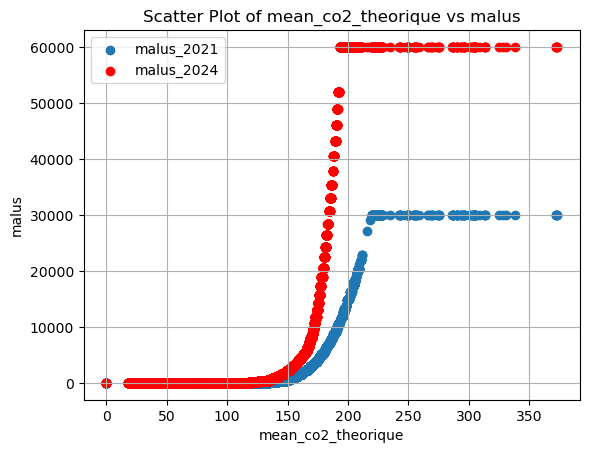

In [35]:
plt.scatter(datap['mean_co2_theorique'], datap['malus_2021'], label='malus_2021')
plt.scatter(datap['mean_co2_theorique'], datap['malus_2024'], label='malus_2024', color='r')
plt.title('Montant du malus')
plt.xlabel('mean_co2_theorique')
plt.ylabel('malus')
plt.grid(True)  # Optional: Adds a grid for better readability
plt.legend()
plt.show()

In [36]:
print(datap['malus_2021'].mean())
print(np.average(datap['malus_2021'], weights=datap['VOLUME']))

698.8260891552252
187.87181296990966


## 6. Affichage de l'effet des différents malus sur les emissions moyennes de CO2

In [39]:
m_guess = np.zeros(datap['VOLUME'].size)
m_guess

array([0., 0., 0., ..., 0., 0., 0.])

### Effet malus 2021 basé sur CO2 théorique

In [40]:
# categorisation selon le malus 2021 théorique
bins_limits = np.concatenate([np.array([0, 132])] + [malus_2021_df['CO2'][1:-1].values] + [np.array([219, 420])])

# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_theorique'], bins=bins_limits, include_lowest=True, right=False)
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

# malus
malus_2021=datap.groupby('CO2bins')['malus_2021'].mean() #2021 sur theorique

In [43]:
p

CO2bins
[0, 132)       27965.388860
[132, 133)     28634.642975
[133, 134)     28779.890471
[134, 135)     29522.407437
[135, 136)     33008.878360
                  ...      
[215, 216)              NaN
[216, 217)     96297.000000
[217, 218)              NaN
[218, 219)    102375.000000
[219, 420)    109553.860800
Length: 89, dtype: float64

## effet malus 2021 basé sur le co2 réel

In [44]:
# categorisation selon le malus 2021 réel
bins_limits = np.concatenate([np.array([0, 132])] + [malus_2021_df['CO2'][1:-1].values] + [np.array([219, 420])])

# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_reel'], bins=bins_limits, include_lowest=True, right=False) #CO2 réel
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

malus_2021_reel = datap.groupby('CO2bins')['malus_2021_reel'].min()
malus_2021_reel



CO2bins
[0, 132)          0
[132, 133)        0
[133, 134)       50
[134, 135)       75
[135, 136)      100
              ...  
[215, 216)    26247
[216, 217)    27166
[217, 218)    28107
[218, 219)    29070
[219, 420)    30000
Name: malus_2021_reel, Length: 89, dtype: int64

### Effet malus 2024

In [45]:
datap['malus_2024']

0        60000
1         1761
3            0
7            0
9            0
         ...  
54157      240
54158      240
54202      230
54203      230
54204      230
Name: malus_2024, Length: 39549, dtype: int64

#### a. Visualisation du malus 2024 basé sur le co2 théorique

In [46]:
def make_int(s):
    return int(re.search(r'\d+', s).group())

make_int_vf = np.vectorize(make_int)
make_int_vf(malus_2024_df['CO2'][1:-1].values)

array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193])

## Nouvelle catégorisation 2024 avec plus de catégories élevées 

In [50]:
p

CO2bins
[0, 117)       34036.514591
[117, 118)     21696.348996
[118, 119)     22133.458549
[119, 120)     21616.704205
[120, 121)     20765.294717
                  ...      
[215, 216)              NaN
[216, 217)     96297.000000
[217, 218)              NaN
[218, 219)    102375.000000
[219, 420)    109553.860800
Length: 104, dtype: float64

## malus 2024 sur co2 réel

In [52]:
def make_int(s):
    return int(re.search(r'\d+', s).group())

make_int_vf = np.vectorize(make_int)
liste_bins_malus_2024 = make_int_vf(malus_2024_df['CO2'][1:-1].values)
liste_bins_malus_2024

array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193])

In [64]:
# categorisation selon le malus 2024 sur co2 réel
bins_limits = np.concatenate([np.array([0, 60, 90, 100, 117])] + [liste_bins_malus_2024] +[np.arange(194, 220,3)]+ [np.array([ 420])])
                                                                               
# Découper le DataFrame en bins
datap['CO2bins'] = pd.cut(datap['mean_co2_reel'], bins=bins_limits, include_lowest=True, right=False)
datap['CO2bins']

# creation des moyennes par categorie
nb_vehicules = datap.groupby('CO2bins')['VOLUME'].sum()

datap['Prix_Volume'] = datap['Prix du véhicule'] * datap['VOLUME']
price_by_bin = datap.groupby('CO2bins')['Prix_Volume'].sum()  /nb_vehicules
datap.drop('Prix_Volume', axis=1)
p=price_by_bin

datap['CO2_Volume'] = datap['CO2reel'] * datap['VOLUME']
meanCO2_by_bin = datap.groupby('CO2bins')['CO2_Volume'].sum() / nb_vehicules
CO2reel=meanCO2_by_bin
datap.drop('CO2_Volume', axis =1)

datap['CO2theorique_Volume'] = datap['mean_co2_theorique'] * datap['VOLUME']
CO2theorique=datap.groupby('CO2bins')['CO2theorique_Volume'].sum() / nb_vehicules
datap.drop('CO2theorique_Volume', axis =1)

# malus
malus_2024_reel=datap.groupby('CO2bins')['malus_2024_reel'].mean()

In [65]:
malus_2024_reel

CO2bins
[0, 60)           0.0
[60, 90)          0.0
[90, 100)         0.0
[100, 117)        0.0
[117, 118)        0.0
               ...   
[206, 209)    60000.0
[209, 212)    60000.0
[212, 215)    60000.0
[215, 218)    60000.0
[218, 420)    60000.0
Name: malus_2024_reel, Length: 90, dtype: float64

In [66]:
p

CO2bins
[0, 60)       48424.338402
[60, 90)      46524.975766
[90, 100)     50136.850764
[100, 117)    28936.667429
[117, 118)    29230.459290
                  ...     
[206, 209)    54331.880859
[209, 212)    42323.159395
[212, 215)    73564.338028
[215, 218)    56419.785791
[218, 420)    77440.391569
Length: 90, dtype: float64

In [62]:
datap.groupby('CO2bins')['VOLUME'].sum()

CO2bins
[0, 117)      189745
[117, 118)     10366
[118, 119)      5465
[119, 120)     25352
[120, 121)      3918
               ...  
[215, 216)       408
[216, 217)       770
[217, 218)       694
[218, 219)        68
[219, 420)      2399
Name: VOLUME, Length: 104, dtype: int64